## Dataset Overview

This analysis uses multiple geospatial datasets to assess wildfire risk in Los Angeles County:

### Vector Data (Shapefiles)
1. **Los Angeles County Boundary** (`la_county_boundary.shp`)
   - Administrative boundary for Los Angeles County
   - Used to clip and focus analysis on the study area

2. **California Census Tracts** (`ca_census_tracts.shp`)
   - Census tract polygons covering California
   - Provides geographic units for demographic and risk analysis

3. **California Railway** (`ca_railway.shp`)
   - Railway network lines across California
   - Used to analyze wildfire risk along transportation corridors

### Tabular Data
4. **California Census Table** (`ca_census_table.csv`)
   - Population and demographic statistics for census tracts
   - Contains population counts and other socioeconomic indicators

### Raster Data
5. **California Wildfire Hazard Potential** (`ca_whp.tif`)
   - GeoTIFF raster file with 270m spatial resolution
   - Classifies areas into wildfire hazard levels (1-7):
     - 1: Very Low
     - 2: Low
     - 3: Moderate
     - 4: High
     - 5: Very High
     - 6: Developed
     - 7: Water

Before loading the data, we define file paths for all datasets. This approach makes the code more maintainable and easier to update if file locations change. All data files are organized in the `data` directory with subdirectories for different data types (vector, table, and raster).

In [25]:
# Vector
la_county_boundary = "data/vector/la_county_boundary.shp"
ca_census_tracts = "data/vector/ca_census_tracts.shp"
ca_railway = "data/vector/ca_railway.shp"

# Table
ca_census_table = "data/table/ca_census_table.csv"

# Raster
ca_whp = "data/raster/ca_whp.tif"

## GeoPandas and Vectors
**GeoPandas** is an open-source Python library that extends the popular pandas library to work with geospatial data. It combines the data manipulation capabilities of pandas with the geometric operations of shapely and the spatial analysis features of fiona and pyproj. GeoPandas makes it easy to work with vector data (points, lines, and polygons) in Python, allowing you to read/write various GIS file formats (like Shapefiles, GeoJSON), perform spatial operations (buffer, intersection, union), and create maps.

Key features:
- Read and write multiple spatial file formats (Shapefile, GeoJSON, GeoPackage, etc.)
- Perform spatial operations (buffer, clip, intersection, union, etc.)
- Spatial joins and overlays
- Coordinate reference system (CRS) transformations
- Integration with matplotlib for basic plotting
- Seamless integration with pandas for data manipulation

Learn more at the [GeoPandas official website](https://geopandas.org/).

### Import GeoPandas
**`import geopandas as gpd`**: This line brings in the powerful **GeoPandas** library, which lets us easily work with **geospatial data** (like shapefiles and GeoJSON) in Python.

The part of the command that reads `as gpd` is a common Python convention (a widely accepted, unofficial standard) used to **create an alias** or a shorter nickname for the library.

In [26]:
import geopandas as gpd

### Read Vectors

**`gpd.read_file()`** reads geospatial files (Shapefile, GeoJSON, etc.) and returns a GeoDataFrame with a special `geometry` column for spatial data.

**`.head()`** displays the first 5 rows of the data to quickly inspect its structure and contents.

In [27]:
# Read LA County Boundary Shapefile
la_county_boundary_gdf = gpd.read_file(la_county_boundary)

In [28]:
type(la_county_boundary_gdf)

geopandas.geodataframe.GeoDataFrame

### GeoDataFrame

A **GeoDataFrame** is like a pandas DataFrame but with a special `geometry` column that stores spatial shapes (points, lines, or polygons). This allows you to combine attribute data (like names, IDs, population) with geographic information in a single table, making it easy to perform both data analysis and spatial operations.

In [29]:
# Display the first few rows of the GeoDataFrame
la_county_boundary_gdf.head()

,GISJOIN,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,...,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,G0600370,06,037,00277283,06037,Los Angeles,Los Angeles County,06,H1,G4020,...,31080,31084,A,1.051349e+10,1.787502e+09,+34.1963983,-118.2618616,863553.138118,1.058205e+10,"MULTIPOLYGON (((-118.42613 32.79983, -118.4261..."


The output shows the GeoDataFrame's structure with multiple columns containing attribute data (like `STATEFP`, `COUNTYFP`, `NAME`, etc.) and a special `geometry` column on the far right that stores the actual polygon shape representing LA County's boundary. Each row represents one geographic feature - in this case, there's just one row for the single LA County boundary polygon.

### Access Values with `.loc`

**`.loc[row, column]`** allows you to access specific values in a GeoDataFrame by specifying the row index and column name. In the example below, `.loc[0, 'STATEFP']` retrieves the value from the first row (index 0) in the `STATEFP` column. This is useful for extracting individual attribute values that you need for further analysis or filtering.

In [30]:
# Access value of row 0, column 'STATEFP'
statefp = la_county_boundary_gdf.loc[0, 'STATEFP']
# Access value of row 0, column 'COUNTYFP'
countyfp = la_county_boundary_gdf.loc[0, 'COUNTYFP']
# Print the State and County FIPS codes
print(f"State FIPS: {statefp}, County FIPS: {countyfp}")

State FIPS: 06, County FIPS: 037


Now let's read a vector file containing multiple geographic features. 

The California census tracts dataset contains thousands of census tract polygons across the entire state. 

In [31]:
# Read California Census Tracts Shapefile
ca_census_tracts_gdf = gpd.read_file(ca_census_tracts)

Let's take a look at the GeoDataFrame

In [32]:
# Display the first few rows of the GeoDataFrame
ca_census_tracts_gdf.head()

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,G0600010400100,06,001,400100,06001400100,4001,Census Tract 4001,G5020,S,6945857.0,0.0,+37.8676563,-122.2318813,14242.773440,6.945853e+06,"POLYGON ((-122.21292 37.85778, -122.21296 37.8..."
1,G0600010400200,06,001,400200,06001400200,4002,Census Tract 4002,G5020,S,586560.0,0.0,+37.8481378,-122.2495916,3990.700032,5.865583e+05,"POLYGON ((-122.24191 37.85191, -122.24191 37.8..."
2,G0600010400300,06,001,400300,06001400300,4003,Census Tract 4003,G5020,S,1110840.0,0.0,+37.8405841,-122.2544782,5311.191050,1.110836e+06,"POLYGON ((-122.25081 37.83714, -122.25084 37.8..."
3,G0600010400400,06,001,400400,06001400400,4004,Census Tract 4004,G5020,S,716138.0,0.0,+37.8482840,-122.2574447,3812.082499,7.161367e+05,"POLYGON ((-122.25335 37.85383, -122.25333 37.8..."
4,G0600010400500,06,001,400500,06001400500,4005,Census Tract 4005,G5020,S,591424.0,0.0,+37.8485452,-122.2647353,3292.829056,5.914232e+05,"POLYGON ((-122.26183 37.85258, -122.2617 37.85..."


**`.shape`** returns a tuple showing the dimensions of the GeoDataFrame as (rows, columns). 

In [33]:
# Display dimensions of the GeoDataFrame
ca_census_tracts_gdf.shape

(9109, 16)

This tells us how many features (rows) and attributes (columns) are in the dataset. For example, `(9019, 16)` means 9,019 census tracts with 16 columns of data.

### Select by Attributes

To extract only the census tracts for Los Angeles County from the statewide dataset, we use **attribute filtering**. This is a two-step process:

1. **Create a where clause**: Define a boolean condition that checks which rows match our criteria (in this case, where `COUNTYFP` equals LA County's FIPS code)
2. **Apply the filter**: Use bracket notation `[where_clause]` to select only the rows where the condition is `True`

This filtering technique works just like SQL's WHERE clause or Excel's filter feature, allowing us to subset large datasets based on attribute values.

|ID|COUNTYFP|Boolean Condition|Selected?|
|----|----|----|----|
|1|037|True|Yes|
|2|037|True|Yes|
|3|038|False|No|
|4|039|False|No|

In [34]:
# Filter California Census Tracts for LA County
where_clause = ca_census_tracts_gdf['COUNTYFP'] == countyfp

# Apply the filter
la_county_census_tracts_gdf = ca_census_tracts_gdf[where_clause]

# Display dimensions of the GeoDataFrame
la_county_census_tracts_gdf.shape

(2495, 16)

Attribute filtering also works with numerical comparisons. Here we filter census tracts to find only those with water area (`AWATER > 0`). This demonstrates how to use comparison operators (>, <, >=, <=, ==, !=) to create more flexible queries beyond simple equality checks. 

The `AWATER` column stores water area in square meters, so this filter identifies all census tracts that contain any amount of water—useful for understanding coastal or waterfront areas.

In [35]:
# Filter California Census Tracts
where_clause = ca_census_tracts_gdf['AWATER'] > 0

# Apply the filter
water_census_tracts_gdf = ca_census_tracts_gdf[where_clause]

# Display dimensions of the GeoDataFrame
water_census_tracts_gdf.head()

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
16,G0600010401700,06,001,401700,06001401700,4017,Census Tract 4017,G5020,S,5751454.0,5771096.0,+37.8211635,-122.3187951,17884.503236,5.751450e+06,"POLYGON ((-122.29617 37.83098, -122.29447 37.8..."
29,G0600010403302,06,001,403302,06001403302,4033.02,Census Tract 4033.02,G5020,S,719239.0,104126.0,+37.7937603,-122.2667344,4261.046182,7.192436e+05,"POLYGON ((-122.25955 37.7983, -122.25955 37.79..."
30,G0600010403401,06,001,403401,06001403401,4034.01,Census Tract 4034.01,G5020,S,549686.0,602434.0,+37.8092493,-122.2597833,5382.543851,1.152118e+06,"POLYGON ((-122.25616 37.80901, -122.25622 37.8..."
43,G0600010404300,06,001,404300,06001404300,4043,Census Tract 4043,G5020,S,1817027.0,37495.0,+37.8448210,-122.2385523,6693.648754,1.854521e+06,"POLYGON ((-122.23419 37.85254, -122.23416 37.8..."
45,G0600010404501,06,001,404501,06001404501,4045.01,Census Tract 4045.01,G5020,S,1079143.0,5141.0,+37.8271275,-122.2171515,4689.306813,1.084285e+06,"POLYGON ((-122.2171 37.83276, -122.21704 37.83..."


For more advanced filtering, you can combine multiple conditions using logical operators:
- **`&`** (AND): Both conditions must be True
- **`|`** (OR): At least one condition must be True  
- **`~`** (NOT): Negates a condition

In this example, we use the **AND operator (`&`)** to find census tracts that meet both criteria: they must be in LA County AND contain water. **Important**: Each condition must be wrapped in parentheses when using logical operators.

This technique is powerful for creating precise spatial queries, such as finding coastal areas in a specific region or identifying high-risk zones with certain characteristics.

In [36]:
# Complex where clause
where_clause = (ca_census_tracts_gdf['AWATER'] > 0) & (ca_census_tracts_gdf['COUNTYFP'] == countyfp)

# Apply the filter
complex_filtered_gdf = ca_census_tracts_gdf[where_clause]

# Display dimensions of the GeoDataFrame
complex_filtered_gdf.head()

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
1388,G0600370102107,06,037,102107,06037102107,1021.07,Census Tract 1021.07,G5020,S,12908558.0,13753.0,+34.2409052,-118.3395988,19367.955420,1.292231e+07,"POLYGON ((-118.33 34.25968, -118.32995 34.2596..."
1399,G0600370104124,06,037,104124,06037104124,1041.24,Census Tract 1041.24,G5020,S,4479385.0,980.0,+34.2900933,-118.3741930,12064.109731,4.480364e+06,"POLYGON ((-118.37075 34.28212, -118.37084 34.2..."
1402,G0600370104204,06,037,104204,06037104204,1042.04,Census Tract 1042.04,G5020,S,2660594.0,3735.0,+34.2912875,-118.3931176,9202.436567,2.664327e+06,"POLYGON ((-118.38294 34.29397, -118.38295 34.2..."
1420,G0600370106020,06,037,106020,06037106020,1060.20,Census Tract 1060.20,G5020,S,2010764.0,7144.0,+34.3232264,-118.4294854,7077.522938,2.017908e+06,"POLYGON ((-118.41714 34.32495, -118.41716 34.3..."
1421,G0600370106111,06,037,106111,06037106111,1061.11,Census Tract 1061.11,G5020,S,2774241.0,12394.0,+34.3191370,-118.4095511,8531.549869,2.786638e+06,"POLYGON ((-118.40079 34.31632, -118.4008 34.31..."


### Validate with `.plot()`

After filtering, it's good practice to visualize the results to confirm the selection worked correctly. **`.plot()`** is a built-in GeoPandas method that creates a simple matplotlib map of the geometries. This quick visualization helps us verify that we've successfully extracted only the LA County census tracts and that the spatial data looks correct.

<Axes: >

<Axes: >

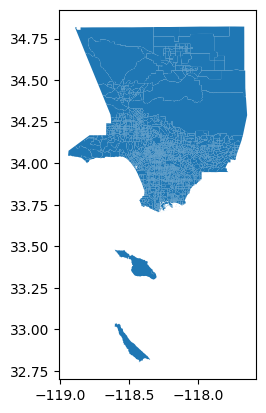

In [37]:
# Plot the LA County Census Tracts to validate the filter
la_county_census_tracts_gdf.plot()

To see the full statewide dataset and verify our LA County filter worked correctly, we can plot all California census tracts with each county shown in a different color. 

The **`column='COUNTYFP'`** parameter tells GeoPandas to color the tracts based on the `COUNTYFP` (County FIPS code) values, and **`cmap='tab20'`** specifies a colormap with 20 distinct colors—ideal for distinguishing multiple counties.

<Axes: >

<Axes: >

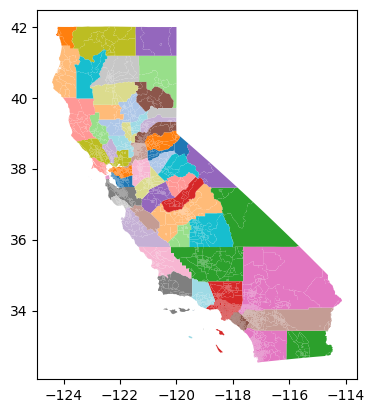

In [38]:
# Plot the California Census Tracts to see all tracts
# Use 'COUNTYFP' to color by county
ca_census_tracts_gdf.plot(column='COUNTYFP', cmap='tab20')

### Select by Location

Beyond attribute filtering, GeoPandas enables **spatial filtering** based on geometric relationships between features. This is one of the most powerful aspects of GIS analysis.

The **`.intersects()`** method tests whether geometries spatially overlap or touch each other. In this example, we filter the statewide railway dataset to find only the railway segments that intersect with LA County's boundary.

**Spatial relationship methods in GeoPandas:**
- `.intersects()` - geometries overlap or touch
- `.contains()` - one geometry fully contains another
- `.within()` - one geometry is fully inside another
- `.touches()` - geometries share a boundary but don't overlap
- `.crosses()` - geometries intersect but don't contain each other

We use **`.union_all()`** to combine all geometries in the boundary GeoDataFrame into a single geometry for efficient spatial comparison.

<Axes: >

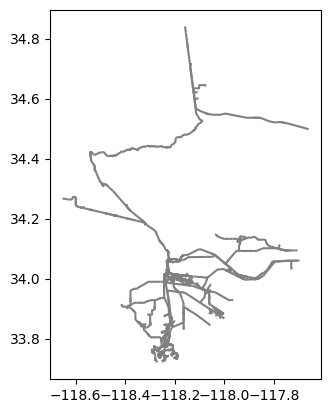

In [47]:
# Read California Railway Shapefile
ca_railway_gdf = gpd.read_file(ca_railway)

# Select railways that intersect with LA County boundary using spatial relationship
# This creates a boolean mask where True means the railway intersects LA County
where_clause = ca_railway_gdf.intersects(la_county_boundary_gdf.union_all())

# Apply the spatial filter
la_railway_gdf = ca_railway_gdf[where_clause]

# Display the filtered railway features
la_railway_gdf.plot(color='gray')

# Display the California railway features
# ca_railway_gdf.plot()

### Read Tables

For non-spatial tabular data (like CSV files), we use **pandas** instead of GeoPandas. The **`pd.read_csv()`** function reads CSV files and returns a standard DataFrame without geometry columns.

In [48]:
import pandas as pd

# Read Tables
ca_census_table_df = pd.read_csv(ca_census_table)   

# Display the first few rows of the DataFrame
ca_census_table_df.head()

,GISJOIN,YEAR,STUSAB,GEOID,GEOCODE,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,...,U7J002,U7J003,U7J004,U7J005,U7J006,U7J007,U7J008,U8R001,U8R002,U8R003
0,G0100010020100,2020,AL,1400000US01001020100,1001020100,3,6,Alabama,1,Autauga County,...,1389,213,5,8,3,35,122,40.6,39.8,42.1
1,G0100010020200,2020,AL,1400000US01001020200,1001020200,3,6,Alabama,1,Autauga County,...,842,1104,2,12,4,20,71,38.8,36.3,40.6
2,G0100010020300,2020,AL,1400000US01001020300,1001020300,3,6,Alabama,1,Autauga County,...,2244,714,12,14,6,49,177,38.8,36.8,41.0
3,G0100010020400,2020,AL,1400000US01001020400,1001020400,3,6,Alabama,1,Autauga County,...,3578,327,17,32,1,38,253,43.8,41.0,46.6
4,G0100010020501,2020,AL,1400000US01001020501,1001020501,3,6,Alabama,1,Autauga County,...,3241,632,29,93,2,58,267,40.6,38.6,42.6


This Census 2020 table contains demographic data for California census tracts, including total population, race, and age distributions. 

For this wildfire risk analysis, we're specifically interested in the **total population** (`U7H001`) for each census tract, which we'll use to identify vulnerable populations in high-risk areas.

In [49]:
# Filter for Los Angeles County
where_clause = ca_census_table_df['COUNTY'] == 'Los Angeles County'

# Select relevant columns
use_col = ['GISJOIN', 'NAME', 'U7H001']

# Apply filter and select columns
la_county_census_table_df = ca_census_table_df[where_clause][use_col]

# Rename the population column for clarity
la_county_census_table_df = la_county_census_table_df.rename(columns={'U7H001': 'POPULATION'})

# Display the filtered DataFrame
la_county_census_table_df.head()

,GISJOIN,NAME,POPULATION
5584,G0600370101110,Census Tract 1011.10,4926
5585,G0600370101122,Census Tract 1011.22,3728
5586,G0600370101220,Census Tract 1012.20,3344
5587,G0600370101221,Census Tract 1012.21,3444
5588,G0600370101222,Census Tract 1012.22,2808


### Display with Interactive Map

While matplotlib `.plot()` creates static maps, **[Leafmap](https://leafmap.org/)** enables us to create interactive web maps effortlessly. 

With just a few lines of code, we can add geospatial layers, zoom, pan, and explore our data dynamically—perfect for presentations and exploratory analysis.

In [51]:
import leafmap

# Create a leafmap Map object
m = leafmap.Map()

# Add the LA County boundary to the map
m.add_gdf(la_county_boundary_gdf, layer_name='LA County Boundary')

# Zoom to the extent of the LA County boundary
m.zoom_to_gdf(la_county_boundary_gdf)

# Display the map
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [ ]:
import rasterio

# Read the California WHP raster file
with rasterio.open(ca_whp) as src:
    ca_whp_data = src.read(1)  # Read the first band
    ca_whp_meta = src.meta
    ca_whp_transform = src.transform
    ca_whp_crs = src.crs

print(f"Raster shape: {ca_whp_data.shape}")
print(f"CRS: {ca_whp_crs}")
print(f"Spatial resolution: 270m")
print(f"Metadata: {ca_whp_meta}")

Raster shape: (4484, 2629)
CRS: EPSG:5070
Spatial resolution: 270m
Metadata: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 2629, 'height': 4484, 'count': 1, 'crs': CRS.from_wkt('PROJCS["NAD83 / Conus Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","5070"]]'), 'transform': Affine(270.0, 0.0, -2356155.000000001,
       0.0, -270.0, 2452814.999999998)}


In [ ]:
from rasterio.mask import mask
import rasterio

# Reproject LA County boundary to match the raster CRS if needed
la_county_boundary_reprojected = la_county_boundary_gdf.to_crs(ca_whp_crs)

# Clip the California WHP raster with LA County boundary
with rasterio.open(ca_whp) as src:
    # Mask the raster with the LA County boundary geometry
    out_image, out_transform = mask(src, la_county_boundary_reprojected.geometry, crop=True)
    out_meta = src.meta.copy()
    
    # Update metadata for the clipped raster
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

# Save the clipped raster
output_tif = "data/raster/la_county_whp.tif"
with rasterio.open(output_tif, "w", **out_meta) as dest:
    dest.write(out_image)

print(f"Clipped raster saved to {output_tif}")

Clipped raster saved to data/raster/la_county_whp.tif


In [ ]:
la_county_whp = 'data/raster/la_county_whp.tif'
# Read LA County WHP raster
with rasterio.open(la_county_whp) as src:
    la_county_whp_rio = src.read(1)
    la_county_whp_transform = src.transform
    la_county_whp_crs = src.crs

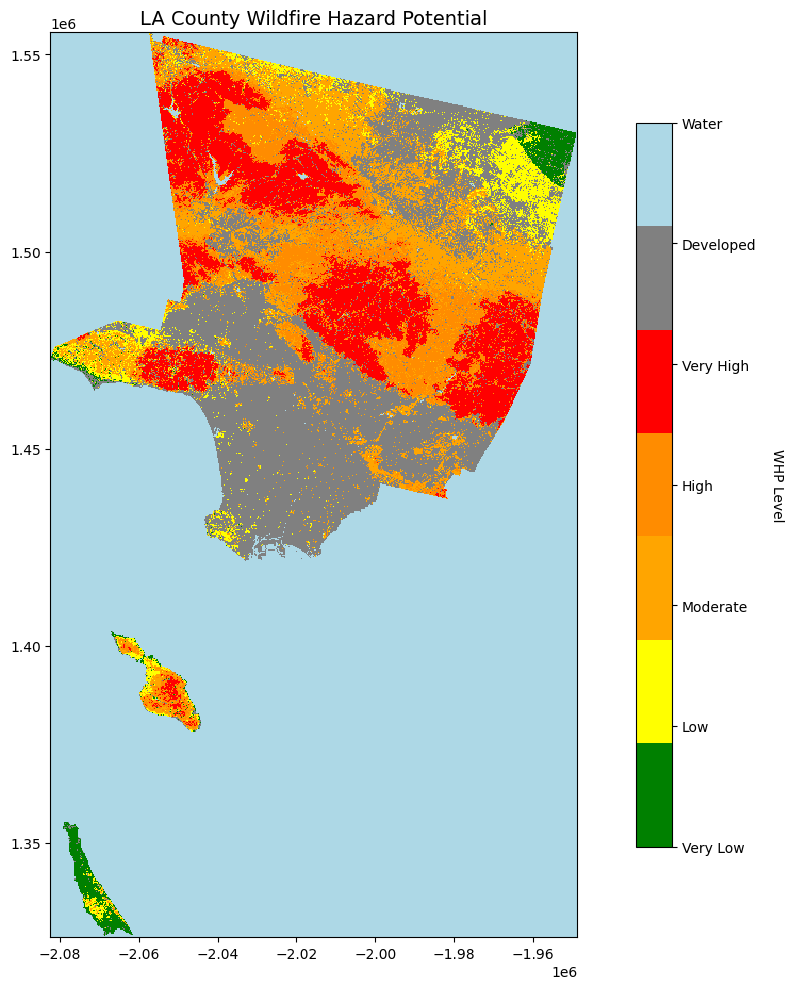

In [ ]:
from rasterio.plot import show
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

# Create custom colormap
# Values 1-5: green to red gradient, 6: gray (developed), 7: lightblue (water)
colors = ['green', 'yellow', 'orange', 'darkorange', 'red', 'gray', 'lightblue']
cmap = ListedColormap(colors)

# Display the clipped LA County WHP raster with custom colormap
fig, ax = plt.subplots(figsize=(12, 10))

# Use rasterio.plot.show with the clipped output
show(la_county_whp_rio, transform=la_county_whp_transform, ax=ax, cmap=cmap, vmin=1, vmax=7, interpolation='nearest')
ax.set_title('LA County Wildfire Hazard Potential', fontsize=14)

# Add colorbar with labels
im = ax.images[0]
cbar = plt.colorbar(im, ax=ax, ticks=[1, 2, 3, 4, 5, 6, 7], shrink=0.8)
cbar.set_label('WHP Level', rotation=270, labelpad=20)
cbar.ax.set_yticklabels(['Very Low', 'Low', 'Moderate', 'High', 'Very High', 'Developed', 'Water'])

plt.tight_layout()
plt.show()


In [ ]:
import xarray
# Add the LA County WHP raster to the leafmap with custom colormap
m.add_raster(la_county_whp, layer_name='LA County WHP', colormap=colors, vmin=1, vmax=7)
m

Map(center=[33.907641999999996, -118.166902], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom…

In [ ]:
la_county_census_tracts_gdf = la_county_census_tracts_gdf.merge(
    la_county_census_table_df, 
    on='GISJOIN', 
    how='left'
)
la_county_census_tracts_gdf.head()

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME_x,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry,NAME_y,POPULATION
0,G0600370101110,06,037,101110,06037101110,1011.10,Census Tract 1011.10,G5020,S,1142401.0,0.0,+34.2594737,-118.2929869,4585.520052,1.142400e+06,"POLYGON ((-118.29792 34.26322, -118.29696 34.2...",Census Tract 1011.10,4926
1,G0600370101122,06,037,101122,06037101122,1011.22,Census Tract 1011.22,G5020,S,2644045.0,0.0,+34.2677213,-118.2901465,9652.233049,2.644046e+06,"POLYGON ((-118.27742 34.2599, -118.27746 34.25...",Census Tract 1011.22,3728
2,G0600370101220,06,037,101220,06037101220,1012.20,Census Tract 1012.20,G5020,S,698886.0,0.0,+34.2516083,-118.2816328,3870.684865,6.988841e+05,"POLYGON ((-118.28498 34.25589, -118.28449 34.2...",Census Tract 1012.20,3344
3,G0600370101221,06,037,101221,06037101221,1012.21,Census Tract 1012.21,G5020,S,354178.0,0.0,+34.2543290,-118.2925767,2781.494135,3.541765e+05,"POLYGON ((-118.28733 34.2559, -118.28733 34.25...",Census Tract 1012.21,3444
4,G0600370101222,06,037,101222,06037101222,1012.22,Census Tract 1012.22,G5020,S,296512.0,0.0,+34.2513519,-118.2885261,3042.743329,2.965130e+05,"POLYGON ((-118.28592 34.2559, -118.28592 34.25...",Census Tract 1012.22,2808


In [ ]:
use_col = ['GISJOIN', 'STATEFP', 'COUNTYFP', 'ALAND', 'AWATER', 'POPULATION', 'geometry']
la_county_census_tracts_gdf = la_county_census_tracts_gdf[use_col]
la_county_census_tracts_gdf.head()

,GISJOIN,STATEFP,COUNTYFP,ALAND,AWATER,POPULATION,geometry
0,G0600370101110,06,037,1142401.0,0.0,4926,"POLYGON ((-118.29792 34.26322, -118.29696 34.2..."
1,G0600370101122,06,037,2644045.0,0.0,3728,"POLYGON ((-118.27742 34.2599, -118.27746 34.25..."
2,G0600370101220,06,037,698886.0,0.0,3344,"POLYGON ((-118.28498 34.25589, -118.28449 34.2..."
3,G0600370101221,06,037,354178.0,0.0,3444,"POLYGON ((-118.28733 34.2559, -118.28733 34.25..."
4,G0600370101222,06,037,296512.0,0.0,2808,"POLYGON ((-118.28592 34.2559, -118.28592 34.25..."


In [ ]:
la_county_census_tracts_gdf['POP_KM2'] = la_county_census_tracts_gdf['POPULATION'] / (la_county_census_tracts_gdf['ALAND'] / 1e6)
la_county_census_tracts_gdf.head()

,GISJOIN,STATEFP,COUNTYFP,ALAND,AWATER,POPULATION,geometry,POP_KM2
0,G0600370101110,06,037,1142401.0,0.0,4926,"POLYGON ((-118.29792 34.26322, -118.29696 34.2...",4311.971015
1,G0600370101122,06,037,2644045.0,0.0,3728,"POLYGON ((-118.27742 34.2599, -118.27746 34.25...",1409.960874
2,G0600370101220,06,037,698886.0,0.0,3344,"POLYGON ((-118.28498 34.25589, -118.28449 34.2...",4784.757457
3,G0600370101221,06,037,354178.0,0.0,3444,"POLYGON ((-118.28733 34.2559, -118.28733 34.25...",9723.924129
4,G0600370101222,06,037,296512.0,0.0,2808,"POLYGON ((-118.28592 34.2559, -118.28592 34.25...",9470.105763


In [ ]:
from rasterstats import zonal_stats

# Sample one record from la_county_census_tracts_gdf
sample_tract = la_county_census_tracts_gdf.sample(n=1)
print(f"Sampled Census Tract: {sample_tract['GISJOIN'].values[0]}")
print(f"Population: {sample_tract['POPULATION'].values[0]}")
print(f"Area (km²): {sample_tract['ALAND'].values[0] / 1e6:.2f}")
sample_tract

Sampled Census Tract: G0600370533902
Population: 3840
Area (km²): 0.76


,GISJOIN,STATEFP,COUNTYFP,ALAND,AWATER,POPULATION,geometry,POP_KM2
1717,G0600370533902,06,037,761152.0,0.0,3840,"POLYGON ((-118.15023 33.97426, -118.14978 33.9...",5044.984445


In [ ]:
# Calculate value_counts of cell values from ca_whp.tif using zonal_stats
# Use categorical=True to get counts of each unique value
stats = zonal_stats(
    sample_tract.to_crs(la_county_whp_crs),
    la_county_whp,
    categorical=True,
    nodata=-9999
)

# Extract the value counts from the first (and only) record
whp_value_counts = stats[0]
print("WHP Value Counts:")
print(whp_value_counts)

WHP Value Counts:
{6: 11}


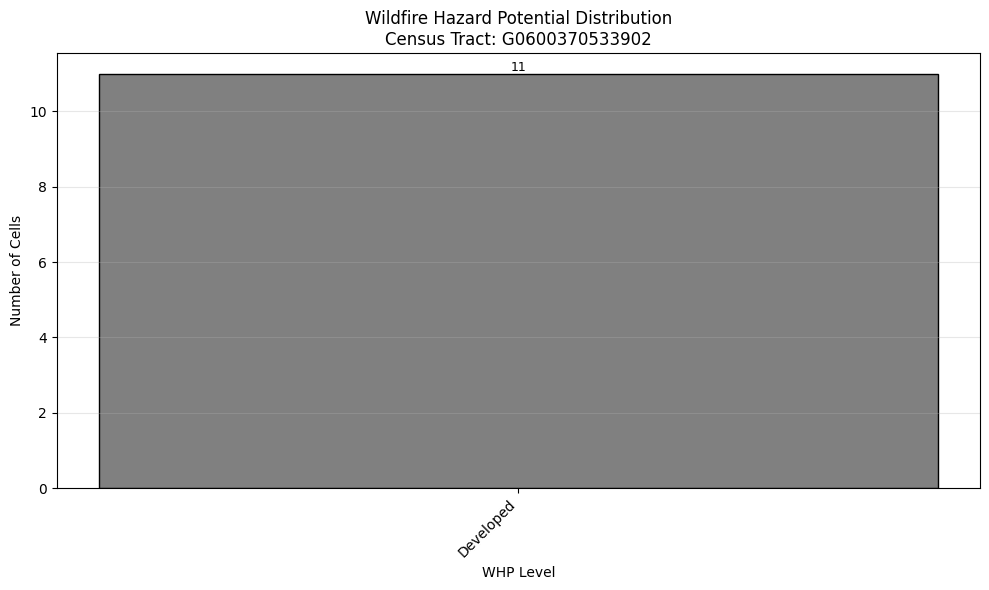

In [ ]:
# Plot the value_counts of WHP values
import matplotlib.pyplot as plt

# Convert to pandas Series for easier plotting
whp_series = pd.Series(whp_value_counts)
whp_series = whp_series.sort_index()

# Define WHP labels
whp_labels = {
    1: 'Very Low',
    2: 'Low',
    3: 'Moderate',
    4: 'High',
    5: 'Very High',
    6: 'Developed',
    7: 'Water'
}

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
colors_map = {1: 'green', 2: 'yellow', 3: 'orange', 4: 'darkorange', 5: 'red', 6: 'gray', 7: 'lightblue'}
bar_colors = [colors_map.get(int(x), 'blue') for x in whp_series.index]

bars = ax.bar(range(len(whp_series)), whp_series.values, color=bar_colors, edgecolor='black')
ax.set_xticks(range(len(whp_series)))
ax.set_xticklabels([whp_labels.get(int(x), f'Value {x}') for x in whp_series.index], rotation=45, ha='right')
ax.set_ylabel('Number of Cells')
ax.set_xlabel('WHP Level')
ax.set_title(f'Wildfire Hazard Potential Distribution\nCensus Tract: {sample_tract["GISJOIN"].values[0]}')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, whp_series.values)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
            f'{int(value):,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
def calculate_whp_count_by_geometry(geometry):
    """
    Calculate the value counts of WHP raster cells within a given geometry.
    
    Parameters:
    -----------
    geometry : shapely geometry
        The geometry to calculate WHP value counts for
    
    Returns:
    --------
    dict
        Dictionary with WHP values as keys and counts as values
    """
    # Calculate zonal stats for the geometry
    stats = zonal_stats(
        [geometry],
        la_county_whp,
        categorical=True,
        nodata=-9999
    )

    total = zonal_stats(        
        [geometry],
        la_county_whp,
        categorical=False,
        nodata=-9999)
    print(total)
    if stats:
        stats[0]['total'] = total[0]['count']
        return stats[0]
    else:
        return {'total': total[0]['count']}


# Test the function with one geometry
test_geometry = la_county_census_tracts_gdf.to_crs(la_county_whp_crs).iloc[0].geometry
test_result = calculate_whp_count_by_geometry(test_geometry)
print("Test result:", test_result)

[{'min': 4.0, 'max': 6.0, 'mean': 5.875, 'count': 16}]
Test result: {4: 1, 6: 15, 'total': 16}


In [ ]:
# Reproject census tracts to match raster CRS
print("Reprojecting census tracts to match raster CRS...")
la_county_census_tracts_reprojected = la_county_census_tracts_gdf.to_crs(la_county_whp_crs)

# Apply the function to each row and store in new column 'whp_counts'
print("Calculating WHP counts for all census tracts...")
la_county_census_tracts_gdf['whp_counts'] = la_county_census_tracts_reprojected.geometry.apply(
    calculate_whp_count_by_geometry
)

print(f"Completed! Added 'whp_counts' column to {len(la_county_census_tracts_gdf)} census tracts")
print("\nFirst few rows with whp_counts:")
la_county_census_tracts_gdf.head()

Reprojecting census tracts to match raster CRS...
Calculating WHP counts for all census tracts...
[{'min': 4.0, 'max': 6.0, 'mean': 5.875, 'count': 16}]
[{'min': 3.0, 'max': 6.0, 'mean': 5.428571428571429, 'count': 35}]
[{'min': 4.0, 'max': 6.0, 'mean': 5.75, 'count': 8}]
[{'min': 6.0, 'max': 6.0, 'mean': 6.0, 'count': 4}]
[{'min': 6.0, 'max': 6.0, 'mean': 6.0, 'count': 5}]
[{'min': 3.0, 'max': 6.0, 'mean': 5.4, 'count': 35}]
[{'min': 3.0, 'max': 6.0, 'mean': 4.325842696629214, 'count': 89}]
[{'min': 3.0, 'max': 6.0, 'mean': 5.0625, 'count': 16}]
[{'min': 3.0, 'max': 6.0, 'mean': 5.391304347826087, 'count': 23}]
[{'min': 6.0, 'max': 6.0, 'mean': 6.0, 'count': 5}]
[{'min': 3.0, 'max': 6.0, 'mean': 4.055555555555555, 'count': 180}]
[{'min': 3.0, 'max': 6.0, 'mean': 4.925925925925926, 'count': 27}]
[{'min': 6.0, 'max': 6.0, 'mean': 6.0, 'count': 17}]
[{'min': 2.0, 'max': 6.0, 'mean': 5.111111111111111, 'count': 27}]
[{'min': 3.0, 'max': 6.0, 'mean': 4.415384615384616, 'count': 65}]
[{'min

,GISJOIN,STATEFP,COUNTYFP,ALAND,AWATER,POPULATION,geometry,POP_KM2,whp_counts
0,G0600370101110,06,037,1142401.0,0.0,4926,"POLYGON ((-118.29792 34.26322, -118.29696 34.2...",4311.971015,"{4: 1, 6: 15, 'total': 16}"
1,G0600370101122,06,037,2644045.0,0.0,3728,"POLYGON ((-118.27742 34.2599, -118.27746 34.25...",1409.960874,"{3: 1, 4: 5, 5: 7, 6: 22, 'total': 35}"
2,G0600370101220,06,037,698886.0,0.0,3344,"POLYGON ((-118.28498 34.25589, -118.28449 34.2...",4784.757457,"{4: 1, 6: 7, 'total': 8}"
3,G0600370101221,06,037,354178.0,0.0,3444,"POLYGON ((-118.28733 34.2559, -118.28733 34.25...",9723.924129,"{6: 4, 'total': 4}"
4,G0600370101222,06,037,296512.0,0.0,2808,"POLYGON ((-118.28592 34.2559, -118.28592 34.25...",9470.105763,"{6: 5, 'total': 5}"


In [ ]:
# Calculate pct_high_risk column
# High risk = WHP values 4 (High) and 5 (Very High)

def calculate_pct_high_risk(whp_counts):
    """
    Calculate the percentage of high-risk areas (WHP 4 and 5) from whp_counts dictionary.
    
    Parameters:
    -----------
    whp_counts : dict
        Dictionary with WHP values as keys and counts as values, including 'total'
    
    Returns:
    --------
    float
        Percentage of high-risk cells (0-100)
    """
    if not whp_counts or whp_counts.get('total', 0) == 0:
        return 0.0
    
    # Get counts for WHP 4 (High) and 5 (Very High)
    high_count = whp_counts.get(4, 0)
    very_high_count = whp_counts.get(5, 0)
    total_count = whp_counts.get('total', 0)
    
    # Calculate percentage
    pct_high_risk = ((high_count + very_high_count) / total_count) * 100
    
    return round(pct_high_risk, 2)

# Apply the function to calculate pct_high_risk for each census tract
la_county_census_tracts_gdf['pct_high_risk'] = la_county_census_tracts_gdf['whp_counts'].apply(
    calculate_pct_high_risk
)

print("Added 'pct_high_risk' column")
print(f"\nSummary statistics for pct_high_risk:")
print(la_county_census_tracts_gdf['pct_high_risk'].describe())
print(f"\nTracts with >50% high risk: {(la_county_census_tracts_gdf['pct_high_risk'] > 50).sum()}")
print(f"Tracts with >75% high risk: {(la_county_census_tracts_gdf['pct_high_risk'] > 75).sum()}")

# Display first few rows
la_county_census_tracts_gdf[['GISJOIN', 'POPULATION','pct_high_risk']].head(10)

Added 'pct_high_risk' column

Summary statistics for pct_high_risk:
count    2495.000000
mean        2.554701
std        10.610338
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        93.660000
Name: pct_high_risk, dtype: float64

Tracts with >50% high risk: 42
Tracts with >75% high risk: 17


,GISJOIN,POPULATION,pct_high_risk
0,G0600370101110,4926,6.25
1,G0600370101122,3728,34.29
2,G0600370101220,3344,12.50
3,G0600370101221,3444,0.00
4,G0600370101222,2808,0.00
5,G0600370101300,4269,31.43
6,G0600370101400,3898,44.94
7,G0600370102103,2107,18.75
8,G0600370102104,3906,4.35
9,G0600370102105,1855,0.00


In [ ]:
# Reproject ca_railway_gdf to match the raster CRS
print("Reprojecting CA railway to match raster CRS...")
ca_railway_reprojected = ca_railway_gdf.to_crs(la_county_whp_crs)
print(f"Original railway features: {len(ca_railway_reprojected)}")
print(f"Railway CRS: {ca_railway_reprojected.crs}")

# Create 270m buffer around the railway
print("\nCreating 270m buffer around railway...")
ca_railway_buffer_gdf = ca_railway_reprojected.copy()
ca_railway_buffer_gdf['geometry'] = ca_railway_reprojected.geometry.buffer(270)
print(f"Buffer created with 270m radius")

# Clip the buffered railway to LA County boundary
print("\nClipping buffered railway to LA County boundary...")
la_county_boundary_raster_crs = la_county_boundary_gdf.to_crs(la_county_whp_crs)
la_railway_buffer_gdf = gpd.clip(ca_railway_buffer_gdf, la_county_boundary_raster_crs)
print(f"LA County railway buffer features: {len(la_railway_buffer_gdf)}")

# Calculate WHP counts for each buffered railway segment
print("\nCalculating WHP counts for buffered railway segments...")
la_railway_buffer_gdf['whp_counts'] = la_railway_buffer_gdf.geometry.apply(
    calculate_whp_count_by_geometry
)

print("\nCompleted WHP analysis for railway buffers!")
print(f"\nFirst few railway segments with WHP counts:")
la_railway_buffer_gdf[['whp_counts']].head()

Reprojecting CA railway to match raster CRS...
Original railway features: 17126
Railway CRS: PROJCS["NAD83 / Conus Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","5070"]]

Creating 270m buffer around railway...
Buffer created with 270m radius

Clipping buffered railway to LA County boundary...
Buffer created with 270m radius

Clipping buffered railway to LA County boundary...
LA County railway buffer features: 372

,whp_counts
9396,"{6: 5, 'total': 5}"
4832,"{6: 5, 'total': 5}"
2634,"{6: 5, 'total': 5}"
4273,"{6: 5, 'total': 5}"
3588,"{6: 5, 'total': 5}"


In [ ]:
# Calculate pct_high_risk for railway buffers using the calculate_pct_high_risk function
print("Calculating pct_high_risk for railway buffers...")
la_railway_gdf['pct_high_risk'] = la_railway_buffer_gdf['whp_counts'].apply(
    calculate_pct_high_risk
)

print("Added 'pct_high_risk' column to railway buffers")
print(f"\nSummary statistics for railway buffer pct_high_risk:")
print(la_railway_gdf['pct_high_risk'].describe())
print(f"\nRailway segments with >50% high risk: {(la_railway_gdf['pct_high_risk'] > 50).sum()}")
print(f"Railway segments with >75% high risk: {(la_railway_gdf['pct_high_risk'] > 75).sum()}")

# Display first few rows with whp_counts and pct_high_risk
print("\nFirst few railway buffer segments with WHP analysis:")
la_railway_gdf[['FRAARCID', 'MILES', 'pct_high_risk']].head(10)

Calculating pct_high_risk for railway buffers...
Added 'pct_high_risk' column to railway buffers

Summary statistics for railway buffer pct_high_risk:
count    3721.000000
mean        0.252303
std         3.672599
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       100.000000
Name: pct_high_risk, dtype: float64

Railway segments with >50% high risk: 7
Railway segments with >75% high risk: 1

First few railway buffer segments with WHP analysis:


,FRAARCID,MILES,pct_high_risk
9396,338086,0.444520,0.0
4832,331126,0.443468,0.0
2634,327859,0.452874,0.0
4273,330293,0.452232,0.0
1185,325711,0.445254,0.0
3588,329259,0.428634,0.0
13903,519314,0.428029,0.0
1517,326201,0.033557,0.0
9648,338467,0.034097,0.0
8361,336440,0.374763,0.0


In [ ]:
la_railway_gdf = la_railway_gdf[['FRAARCID', 'MILES', 'pct_high_risk', 'geometry']]


In [ ]:
# Create a choropleth map of railway segments colored by pct_high_risk
print("Creating choropleth map for railway wildfire risk...")

# Create a new leafmap Map object
railway_map = leafmap.Map(center=[34.05, -118.25], zoom=9)

# Add the railway segments as a choropleth map
railway_map.add_data(
    la_railway_gdf, 
    column='pct_high_risk', 
    scheme='NaturalBreaks', 
    cmap='summer', 
    legend_title='% High Fire Risk (WHP 4 & 5)'
)

# Display the map
print("\nChoropleth map created!")
print("Railway segments are colored by percentage of high fire risk (WHP 4 & 5)")
railway_map

Creating choropleth map for railway wildfire risk...

Choropleth map created!
Railway segments are colored by percentage of high fire risk (WHP 4 & 5)

Choropleth map created!
Railway segments are colored by percentage of high fire risk (WHP 4 & 5)


Map(center=[34.05, -118.25], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [ ]:
# Create a choropleth map of census tracts colored by pct_high_risk
print("Creating choropleth map for census tract wildfire risk...")

# Create a new leafmap Map object
census_map = leafmap.Map(center=[34.05, -118.25], zoom=9)

# Add the census tracts as a choropleth map using add_data
census_map.add_data(
    la_county_census_tracts_gdf[['GISJOIN', 'POPULATION', 'pct_high_risk', 'geometry']], 
    column='pct_high_risk', 
    scheme='NaturalBreaks', 
    cmap='summer', 
    legend_title='% High Fire Risk (WHP 4 & 5)'
)

# Display the map
print("\nChoropleth map created!")
print("Census tracts are colored by percentage of high fire risk (WHP 4 & 5)")
print("Click on a tract to see details")
census_map

Creating choropleth map for census tract wildfire risk...

Choropleth map created!
Census tracts are colored by percentage of high fire risk (WHP 4 & 5)
Click on a tract to see details

Choropleth map created!
Census tracts are colored by percentage of high fire risk (WHP 4 & 5)
Click on a tract to see details


Map(center=[34.05, -118.25], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…